In [1]:
import math
import tqdm
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 

In [2]:
import os
from scipy.io import loadmat
from math import floor
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

data_raw = pd.read_csv('./expData_20240318.csv')
data_index = data_raw.columns[52:52+52].append(data_raw.columns[[104, 105]]) # 106

X = torch.Tensor(np.array(data_raw[data_index]))
# z-scoring 
# X_mean = []
# X_std = []
# for i in range(0, X.shape[1]-2):
#     X[:, i] *= 100

af = data_raw['af']

# Split 
af_unique = np.unique(af)
train_afu, test_afu = train_test_split(af_unique, test_size = .15, random_state = 95 ) # 0 , 70

train_ind = data_raw['af'].isin(train_afu).values
test_ind = data_raw['af'].isin(test_afu).values

# X = data
# X = X - X.min(0)[0]
# X = 2 * (X / X.max(0)[0]) - 1

y = torch.Tensor(data_raw['Cp'])*10
y_mean = torch.mean(y)
y_std = torch.std(y)
# y = (y-torch.mean(y))/torch.std(y)
noise = (torch.Tensor(data_raw['noise'])*10)**2 # 
train_x = X[train_ind]
test_x = X[test_ind]
train_y = y[train_ind]
test_y = y[test_ind]
train_af = data_raw['af'][train_ind]
test_af = data_raw['af'][test_ind]
train_noise = noise[train_ind]
test_noise = noise[test_ind]

# plt.plot(noise)

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()

print(test_afu)

['NLR7301' 'SC1095']


In [21]:
data_dim = train_x.size(-1)
nn_dims = [1000, 500, 50, 6] # 5[1000, 500, 300, 6]
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, nn_dims[0]))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(nn_dims[0], nn_dims[1]))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(nn_dims[1], nn_dims[2]))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(nn_dims[2], nn_dims[3]))
        # self.add_module('relu4', torch.nn.ReLU())
        # self.add_module('linear5', torch.nn.Linear(nn_dims[3], nn_dims[4]))

feature_extractor = LargeFeatureExtractor()

In [22]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            # self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=nn_dims[-1])),
            #     num_dims=nn_dims[-1], grid_size=50
            # )
            # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=nn_dims[-1]))
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=nn_dims[-1])) #gpytorch.kernels.RBFKernel(ard_num_dims=nn_dims[4])
            # self.covar_module.initialize_from_data(train_x, train_y)
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1.0, 1.0)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(train_noise)#gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    
trainNew = True

In [161]:
training_iterations = 50#00*1
import tqdm.notebook as tn 
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# {'params': model.feature_extractor.parameters()},
model = model.cuda()
train_x = train_x.cuda()


optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=1e-4) # 
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

if trainNew == True: 
    best_loss = float('inf')
    best_model_state_dict = None
    trainNew = False
    
print(best_loss)
def train(): 
    global best_loss, best_model_state_dict
    iterator = tn.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        
        # Check if current loss is the best so far <- not sure if working
        # if loss.item() < best_loss:
        #     # print('a')
        #     best_loss = loss.item()
        #     best_model_state_dict = model.state_dict()
            
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()
        
%time train()

# if best_model_state_dict is not None:
#     model.load_state_dict(best_model_state_dict)
    
model.eval()
likelihood.eval()


0.5740460753440857


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 2.3 s, sys: 23.8 ms, total: 2.32 s
Wall time: 2.31 s


FixedNoiseGaussianLikelihood(
  (noise_covar): FixedGaussianNoise()
)

In [162]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds_test = model(test_x)
    preds_train = model(train_x)

print('Train MAE: {}'.format(torch.mean(torch.abs(preds_train.mean - train_y))))
print('Test MAE: {}'.format(torch.mean(torch.abs(preds_test.mean - test_y))))

Train MAE: 0.08777748793363571
Test MAE: 1.9073636531829834


Text(0, 0.5, '$C_p$')

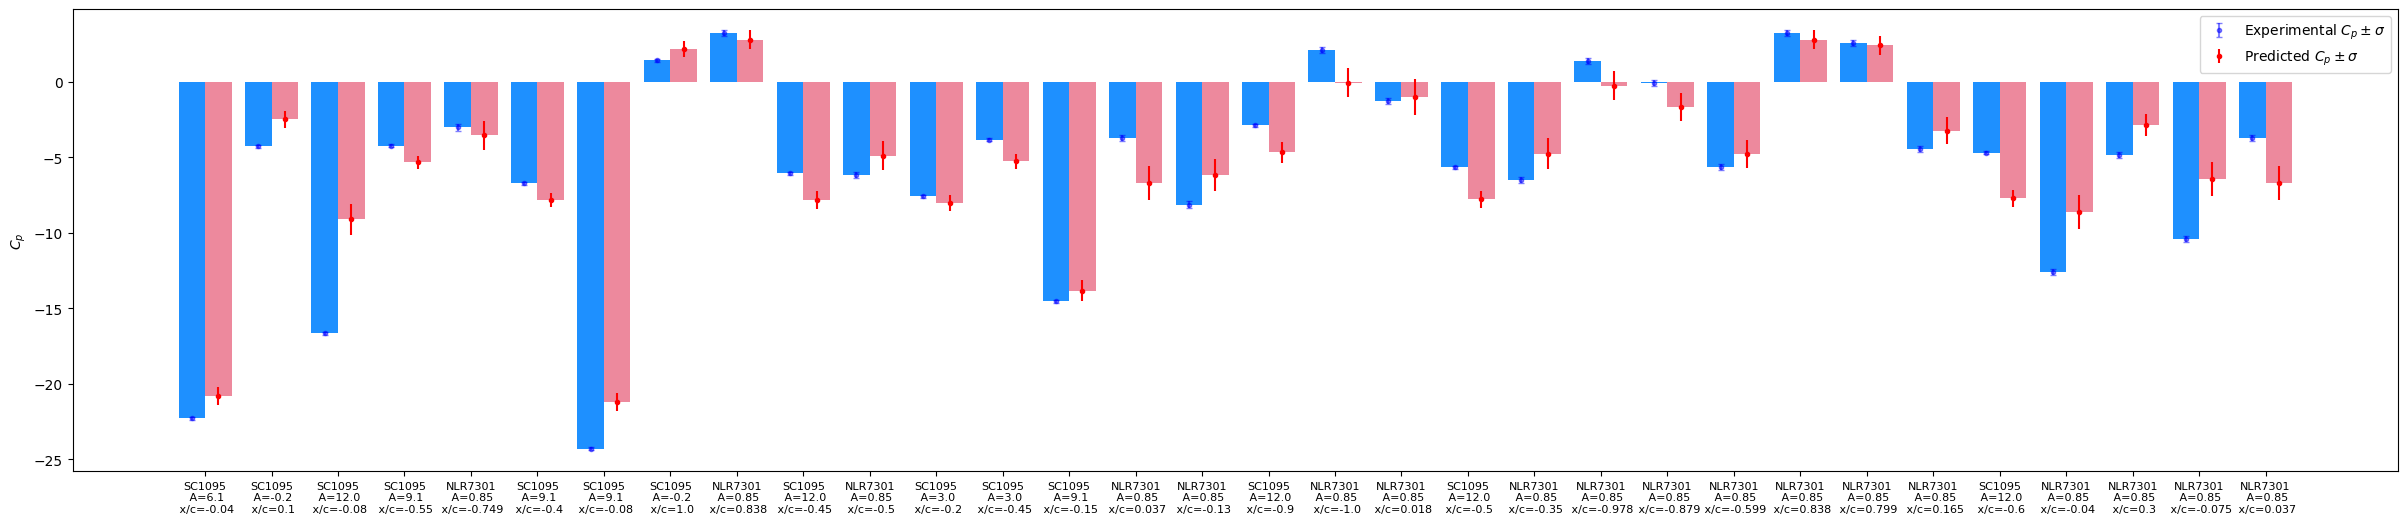

In [163]:

# plt.plot(preds_train.mean.cpu())
# plt.plot(train_y.cpu())

plt.figure(figsize=(30,6))
preds_std = np.sqrt(np.diag(preds_test.covariance_matrix.cpu()))

dispNum = 32
import random
random.seed(30)
# 2 
# test_af[dispInds] + 

# dispInds = random.sample(range(1, test_x.cpu().shape[0]), dispNum)
dispInds1 = random.sample(range(0, test_x.cpu().shape[0]), int(dispNum/2))
dispInds2 = random.sample(range(0, 65), int(dispNum/2))
dispInds = np.concatenate((dispInds1, dispInds2))
# caseStr = 

afStr = np.array(test_af)[dispInds].flatten() # 
locStr = np.array(np.round(test_x.cpu(),3))[dispInds, -1].astype(str).flatten()
AStr = np.array(test_x.cpu())[dispInds, -2].astype(str).flatten()


finalStr = afStr + '\n A=' + AStr + '\n x/c=' + locStr


plt.errorbar(np.arange(len(test_y[dispInds]))-0.2, test_y.cpu()[dispInds], yerr = np.sqrt(test_noise[dispInds]), capsize=2, label='Experimental $C_p \pm \sigma$', fmt='.', color = 'b', alpha =0.5)
plt.bar(np.arange(len(test_y[dispInds]))-0.2, test_y.cpu()[dispInds], color='dodgerblue', width = 0.4)
plt.errorbar(np.arange(len(test_y[dispInds]))+0.2, preds_test.mean.cpu()[dispInds],  yerr = preds_std[dispInds], label='Predicted $C_p \pm \sigma$', fmt='r.')
plt.bar(np.arange(len(test_y[dispInds]))+0.2, preds_test.mean.cpu()[dispInds], color='crimson', width = 0.4, alpha =0.5, capsize=2)
plt.legend()
plt.xticks(np.arange(0, dispNum), finalStr, fontsize=8);
plt.ylabel('$C_p$')

IndexError: index 0 is out of bounds for axis 0 with size 0

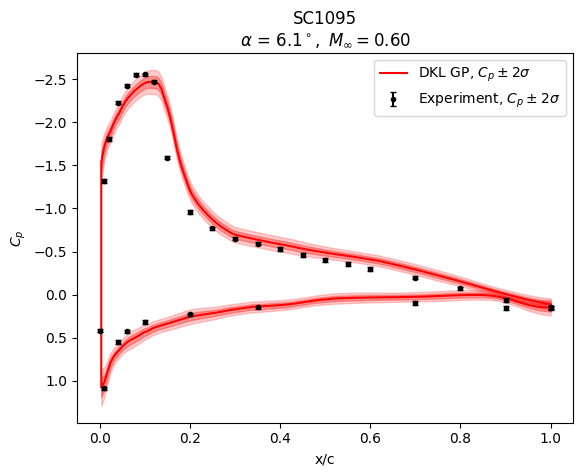

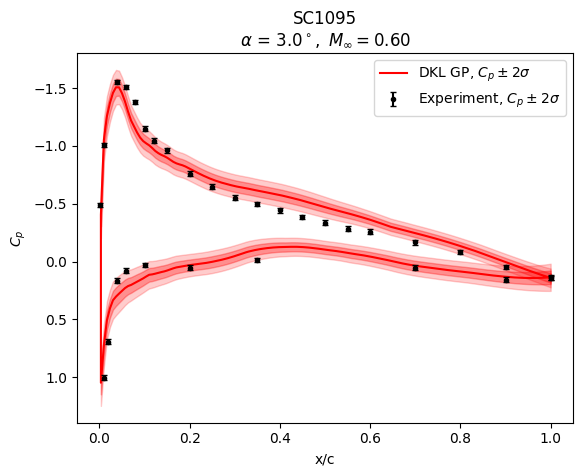

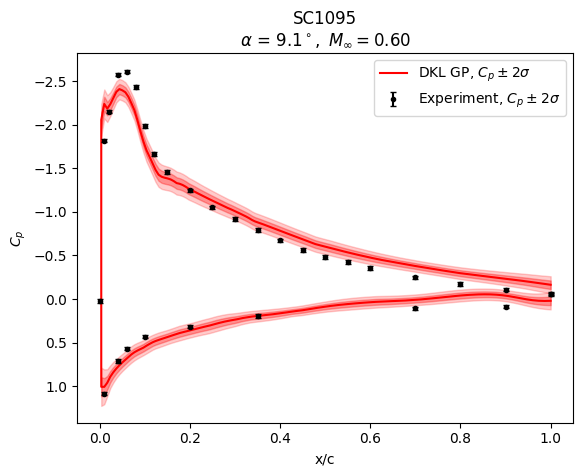

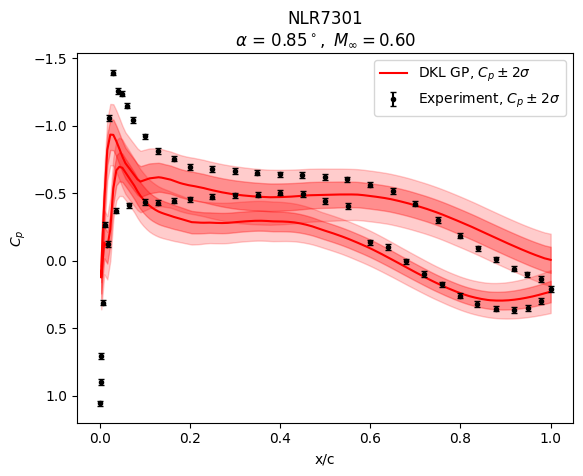

<Figure size 640x480 with 0 Axes>

In [164]:
plotter = [(6.1, test_afu[1]), (3.0, test_afu[1]), (9.1, test_afu[1]), (0.85, test_afu[0]), (9.0, test_afu[0])]
# print(np.where(test_af.values == test_afu[1]))

# plt.plot(test_x.cpu()[:,-2])
# print(test_af)
# print(np.where(test_af.values == test_afu[1]))
for i in np.arange(0, len(plotter)):#[6,7,8,9]:
    plt.figure()
    targetA = plotter[i][0]
    targetAF = plotter[i][1]
    
    
    
    # Search exp 
    tempA = torch.where(test_x[:, -2].cpu() == targetA)[0].numpy()
    tempAF = np.where(test_af.values == targetAF)
    ind_search = np.intersect1d(tempA, tempAF)

    
    # Generate Results 
    sample_airfoil_temp = np.tile(test_x[ind_search[0],:-1].cpu(), (300,1))
    desired_xc = np.linspace(-1, 1, 300).reshape((300,1))
    sample_airfoil = torch.Tensor(np.hstack((sample_airfoil_temp, desired_xc))).cuda()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        sample_airfoil_pred = model(sample_airfoil)
    sample_airfoil_std = np.sqrt(np.diag(sample_airfoil_pred.covariance_matrix.cpu()))
    plt.plot(np.abs(sample_airfoil[:, -1].cpu()), sample_airfoil_pred.mean.cpu()/10 ,'r', label='DKL GP, $C_p \pm 2\sigma$')
    
    # newDist = torch.distributions.multivariate_normal.MultivariateNormal(sample_airfoil_pred.mean.cpu(), sample_airfoil_pred.covariance_matrix.cpu() + torch.eye(sample_airfoil_pred.covariance_matrix.cpu().shape[0])*1e-4)
    
    plt.errorbar(np.abs(test_x[ind_search, -1].cpu()), test_y[ind_search].cpu()/10, yerr=2*np.sqrt(noise[ind_search])/10, fmt='k.', capsize=2, label='Experiment, $C_p \pm 2\sigma$')
    
    # plt.plot(np.abs(sample_airfoil[:, -1].cpu()), sample_airfoil_pred.sample(sample_shape=1) + torch.mean(y))
    plt.fill_between(-desired_xc[:150].flatten(), (sample_airfoil_pred.mean.cpu()[:150] + sample_airfoil_std[:150])/10, (sample_airfoil_pred.mean.cpu()[:150] - sample_airfoil_std[:150])/10, color = 'r', alpha = 0.3)
    plt.fill_between(desired_xc[150:].flatten(), (sample_airfoil_pred.mean.cpu()[150:] + sample_airfoil_std[150:])/10, (sample_airfoil_pred.mean.cpu()[150:] - sample_airfoil_std[150:])/10, color = 'r', alpha = 0.3)
    plt.fill_between(-desired_xc[:150].flatten(), (sample_airfoil_pred.mean.cpu()[:150] + 2*sample_airfoil_std[:150])/10, (sample_airfoil_pred.mean.cpu()[:150] - 2*sample_airfoil_std[:150])/10, color = 'r', alpha = 0.2)
    plt.fill_between(desired_xc[150:].flatten(), (sample_airfoil_pred.mean.cpu()[150:] + 2*sample_airfoil_std[150:])/10, (sample_airfoil_pred.mean.cpu()[150:] - 2*sample_airfoil_std[150:])/10, color = 'r', alpha = 0.2)
    
    # for j in np.arange(0, 5):
    #     plt.plot(np.abs(sample_airfoil[:, -1].cpu()), newDist.sample()+ torch.mean(y), alpha = 0.2, color = 'r')
    
    plt.gca().invert_yaxis()
    plt.xlabel('x/c')
    plt.ylabel('$C_p$')
    plt.legend()
    plt.title(targetAF +'\n' + r'$\alpha$ = ' + str(targetA) + r'$^\circ,$' + r' $M_\infty = 0.60$')
# test_x

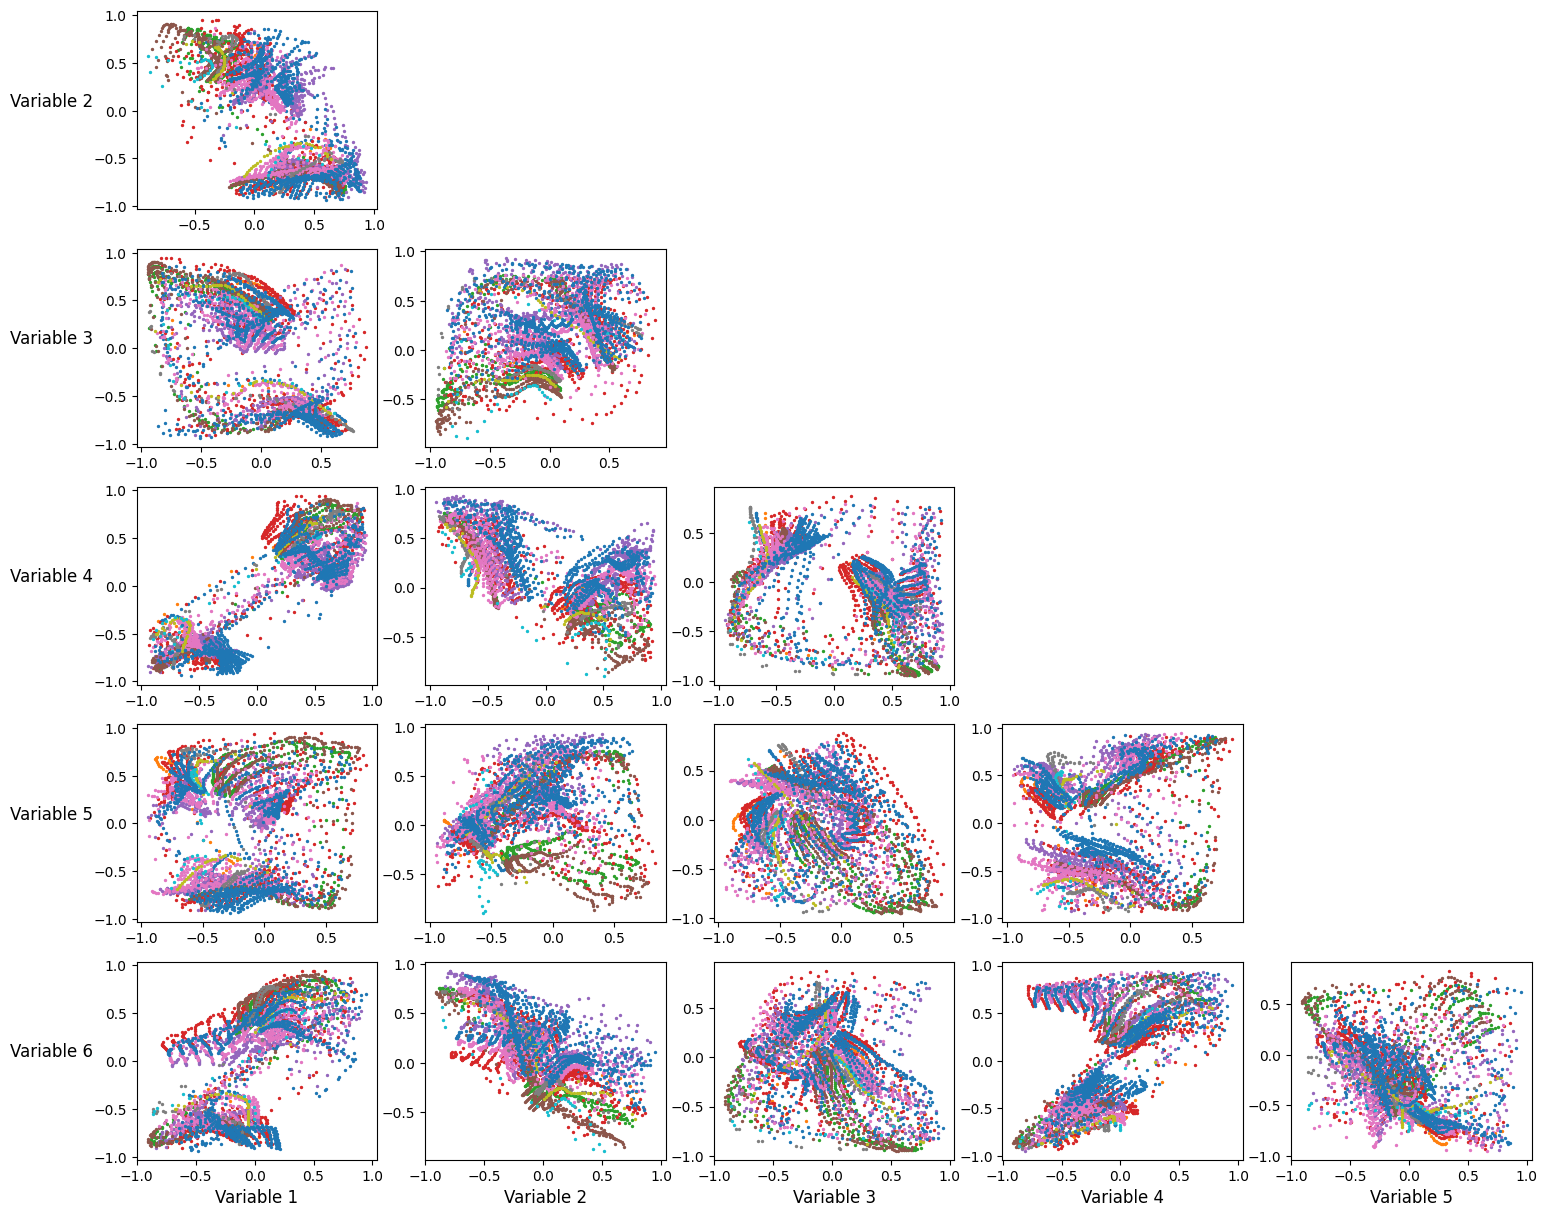

In [166]:
# Latent variable plotter 1 - Latent variables vs each other 
extracted_values = model.feature_extractor(train_x)
extracted_values = model.scale_to_bounds(extracted_values)
extracted_values = extracted_values.cpu().detach().numpy()

N_var = nn_dims[3]
f, ax = plt.subplots(N_var, N_var-1, figsize = (18, 18))
for i in np.arange(0, N_var):
    for j in np.arange(0, i):
        for jj in np.arange(0, train_afu.shape[0]):
            plot_ind = np.argwhere(train_af.values == train_afu[jj])
            ax[i,j].scatter(extracted_values[plot_ind, i], extracted_values[plot_ind, j], marker='.',s=8)
        if j == 0:
            ax[i,j].set_ylabel('Variable ' + str(i+1), rotation=0, fontsize=12, labelpad = 30)
        if i == N_var-1:
            ax[i,j].set_xlabel('Variable ' + str(j+1), rotation=0, fontsize=12)
        
    for k in np.arange(i, N_var-1):
        f.delaxes(ax[i,k])

In [ ]:
# Latent variable plotter 1 - Latent variables vs each other 
extracted_values = model.feature_extractor(train_x)
extracted_values = model.scale_to_bounds(extracted_values)
extracted_values = extracted_values.cpu().detach().numpy()

N_var = nn_dims[3]
f, ax = plt.subplots(N_var, N_var-1, figsize = (18, 18))

# plt.figure()
# plt.scatter(extracted_values[:, 0], extracted_values[:, 1], c=train_y.cpu(), marker='.', s=8)

for i in np.arange(0, N_var):
    for j in np.arange(0, i):
        ff = ax[i,j].scatter(extracted_values[:, i], extracted_values[:, j], c=train_y.cpu(), marker='.', s=8)
        
        if j == 0:
            ax[i,j].set_ylabel('Variable ' + str(i+1), rotation=0, fontsize=12, labelpad = 30)
        if i == N_var-1:
            ax[i,j].set_xlabel('Variable ' + str(j+1), rotation=0, fontsize=12)
        
    for k in np.arange(i, N_var-1):
        f.delaxes(ax[i,k])
        
cbar = plt.colorbar(ff)



In [ ]:
extracted_values = model.feature_extractor(train_x)
extracted_values = model.scale_to_bounds(extracted_values)
extracted_values = extracted_values.cpu().detach().numpy()

N_var = nn_dims[3]
f, ax = plt.subplots(N_var, N_var-1, figsize = (18, 18))
for i in np.arange(0, N_var):
    for j in np.arange(0, i):
        ax[i,j].scatter(extracted_values[:, i], extracted_values[:, j], c=preds_train.mean.cpu(), marker='.', s=8)
        
        if j == 0:
            ax[i,j].set_ylabel('Variable ' + str(i+1), rotation=0, fontsize=12, labelpad = 30)
        if i == N_var-1:
            ax[i,j].set_xlabel('Variable ' + str(j+1), rotation=0, fontsize=12)
        
    for k in np.arange(i, N_var-1):
        f.delaxes(ax[i,k])

In [165]:
torch.save(model.state_dict(), 'semi-working2')

In [23]:
model.load_state_dict(torch.load('semi-working2'))
trainNew = True

In [156]:
plotter = [(2.5, train_afu[2]), (9.1, train_afu[-2])]#, (2.0, train_afu[6])]
print(train_afu)
for i in np.arange(0, len(plotter)):#[6,7,8,9]:
    plt.figure()
    targetA = plotter[i][0]

    targetAF = plotter[i][1]
    tempA = torch.where(train_x[:, -2].cpu() == targetA)[0].numpy()
    tempAF = np.where(train_af.values == targetAF)

    ind_search = np.intersect1d(tempA, tempAF)

    sample_airfoil_temp = np.tile(train_x[ind_search[0],:-1].cpu(), (300,1))
    desired_xc = np.linspace(-1, 1, 300).reshape((300,1))
    sample_airfoil = torch.Tensor(np.hstack((sample_airfoil_temp, desired_xc))).cuda()

    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        sample_airfoil_pred = model(sample_airfoil)
    
    sample_airfoil_std = np.sqrt(np.diag(sample_airfoil_pred.covariance_matrix.cpu()))
    # newDist = torch.distributions.multivariate_normal.MultivariateNormal(sample_airfoil_pred.mean.cpu(), sample_airfoil_pred.covariance_matrix.cpu() + torch.eye(sample_airfoil_pred.covariance_matrix.cpu().shape[0])*1e-5)
    
    plt.errorbar(np.abs(train_x[ind_search, -1].cpu()), (train_y[ind_search].cpu() + torch.mean(y))/10, yerr=2*np.sqrt(train_noise[ind_search])/10, fmt='k.', capsize=2, label='Experiment, $C_p \pm 2\sigma$')
    
    # plt.plot(np.abs(sample_airfoil[:, -1].cpu()), sample_airfoil_pred.sample(sample_shape=1) + torch.mean(y))
    plt.fill_between(-desired_xc[:150].flatten(), (sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) + sample_airfoil_std[:150])/10, (sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) - sample_airfoil_std[:150])/10, color = 'r', alpha = 0.3)
    plt.fill_between(desired_xc[150:].flatten(), (sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) + sample_airfoil_std[150:])/10, (sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) - sample_airfoil_std[150:])/10, color = 'r', alpha = 0.3)
    plt.fill_between(-desired_xc[:150].flatten(),( sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) + 2*sample_airfoil_std[:150])/10, (sample_airfoil_pred.mean.cpu()[:150]+ torch.mean(y) - 2*sample_airfoil_std[:150])/10, color = 'r', alpha = 0.2)
    plt.fill_between(desired_xc[150:].flatten(), (sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) + 2*sample_airfoil_std[150:])/10, (sample_airfoil_pred.mean.cpu()[150:]+ torch.mean(y) - 2*sample_airfoil_std[150:])/10, color = 'r', alpha = 0.2)
    # for j in np.arange(0, 5):
    #     plt.plot(np.abs(sample_airfoil[:, -1].cpu()), newDist.sample()+ torch.mean(y), alpha = 0.2, color = 'r')
    plt.plot(np.abs(sample_airfoil[:, -1].cpu()), (sample_airfoil_pred.mean.cpu() + torch.mean(y))/10,'r', label='DKL GP, $C_p \pm 2\sigma$')
    plt.gca().invert_yaxis()
    plt.xlabel('x/c')
    plt.ylabel('$C_p$')
    plt.legend()
    plt.title(targetAF +'\n' + r'$\alpha$ = ' + str(targetA) + r'$^\circ,$' + r' $M_\infty = 0.60$')

['RAE2822' 'CP7' 'CRA309-A' 'NACA64A410' 'NACA64A006' 'CRA309-B'
 'NACA64A010' 'supercritical9a' 'NACA0012' 'NLRQE0.11-0.75-1.375'
 'NACA64A406']


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 0 Axes>

Quick Cl Cd calculation

In [159]:


manual_Cl = -np.trapz(y=(sample_airfoil_pred.mean.cpu()+torch.mean(y))[:150], x=desired_xc.flatten()[:150]) + np.trapz(y=(sample_airfoil_pred.mean.cpu()+torch.mean(y))[150:], x=desired_xc.flatten()[150:])
# print(np.trapz(y=(sample_airfoil_pred.mean.cpu())[:150]+torch.mean(y), x=desired_xc.flatten()[:150]) + np.trapz(y=(sample_airfoil_pred.mean.cpu())[150:]+torch.mean(y), x=desired_xc.flatten()[150:]))
# torch.linalg.inv(temp_Kxx) @ train_y.cpu()
# print(model.covar_module(train_x))

print(sample_airfoil[0,-2])
def lazy_Cl_Cd_Cm(x, cp, a):
    N = np.trapz(cp[:150], x=np.abs(x.flatten())[:150]) + np.trapz(cp[150:], x=x.flatten()[150:])
    Cl = N * np.cos(np.deg2rad(a))
    Cd = N * np.sin(np.deg2rad(a))
    Cm = np.trapz((np.abs(x.flatten())[:150]-0.25) * cp[:150], x=np.abs(x.flatten())[:150]) + np.trapz((x.flatten()[150:]-0.25) * cp[150:], x=x.flatten()[150:]) # <- double check
    return Cl, Cd, Cm  

import scipy 
def GP_Cl_Cd_Cm(model, train_x, test_data):
    model = model.cpu()
    train_x = train_x.cpu()
    test_data = test_data.cpu()
    
    projected_xtrain = model.feature_extractor(train_x)
    projected_xtrain = model.scale_to_bounds(projected_xtrain)
    projected_xtest = model.feature_extractor(test_data)
    projected_xtest = model.scale_to_bounds(projected_xtest)
    jitter = 1e-5 * torch.eye(train_x.shape[0])
    Kxx = (model.covar_module(projected_xtrain).evaluate().cpu() + train_noise * torch.eye(train_x.shape[0]) + jitter).detach().numpy()
    Lxx = scipy.linalg.cholesky(Kxx, lower = True)
    

    Kss = model.covar_module(projected_xtest, projected_xtest).evaluate().cpu().detach().numpy()
    temp_ind = np.argwhere(np.array(desired_xc).flatten() < 0.0)
    Kss[temp_ind, :] *= -1
    Kss[:, temp_ind] *= -1
    i_Kss = np.trapz(np.trapz(y=Kss, x=np.array(desired_xc).flatten(), axis=0), x=np.array(desired_xc).flatten())
    
    
    # Integrate Kxs 
    Kxs = model.covar_module(projected_xtrain, projected_xtest).evaluate().cpu().detach().numpy()
    KxsT = Kxs.T
    temp_ind = np.argwhere(np.array(desired_xc).flatten() < 0.0)
    KxsT[temp_ind, :] *= -1
    i_Kxs = np.trapz(y=KxsT, x=np.array(desired_xc).flatten(), axis=0).reshape((-1,1)).T
    
    # Cholesky 
    A = scipy.linalg.solve_triangular(Lxx, i_Kxs.T, lower = True)
    v = scipy.linalg.solve_triangular(Lxx, train_y.cpu().numpy(), lower = True)
    
    N = np.dot(np.transpose(A), v) #i_Kxs @ np.linalg.inv(Kxx) @ train_y.cpu().numpy()

    N_std =  np.sqrt(np.diag(i_Kss - np.dot(np.transpose(A), A)))
    a = test_data[0, -2].numpy()
    # print(N_std)
    Cl = N * (np.cos(np.deg2rad(a)) + np.tan(np.deg2rad(a))*np.sin(np.deg2rad(a))) # 
    Cl_std = N_std * np.cos(np.deg2rad(a))
    Cd = N * np.sin(np.deg2rad(a))
    # Cm = np.trapz((np.abs(x.flatten())[:150]-0.25) * cp[:150], x=np.abs(x.flatten())[:150]) + np.trapz((x.flatten()[150:]-0.25) * cp[150:], x=x.flatten()[150:]) # <- double check
    return Cl, Cl_std, Cd   

# lazy_Cl_Cd_Cm(desired_xc.flatten(), (sample_airfoil_pred.mean.cpu()+torch.mean(y)).detach().numpy(), a = 9.1)

Cl_list = []
Cl_std_list = []
Cd_list = []
alpha_vals = np.linspace(-5, 16, 50)
for i in alpha_vals:
    sample_airfoil_temp = np.tile(test_x[58,:-2].cpu(), (300,1)) # test_x[395,:-2]
    a_arr = np.ones((300,1))*i
    desired_xc = np.linspace(-1, 1, 300).reshape((300,1))
    sample_airfoil = torch.Tensor(np.hstack((sample_airfoil_temp, a_arr, desired_xc))).cuda()
    a, b, c = GP_Cl_Cd_Cm(model, train_x, sample_airfoil)
    Cl_list.append(a)
    Cl_std_list.append(b)
    Cd_list.append(c)
Cl_list = np.array(Cl_list).flatten()/10
Cd_list = np.array(Cd_list).flatten()/10
Cl_std_list = np.array(Cl_std_list).flatten()/10

tensor(16., device='cuda:0')


['NACA64A006' 'NACA64A006' 'NACA64A006' ... 'CRA309-B' 'CRA309-B'
 'CRA309-B']
[-5.         -4.57142857 -4.14285714 -3.71428571 -3.28571429 -2.85714286
 -2.42857143 -2.         -1.57142857 -1.14285714 -0.71428571 -0.28571429
  0.14285714  0.57142857  1.          1.42857143  1.85714286  2.28571429
  2.71428571  3.14285714  3.57142857  4.          4.42857143  4.85714286
  5.28571429  5.71428571  6.14285714  6.57142857  7.          7.42857143
  7.85714286  8.28571429  8.71428571  9.14285714  9.57142857 10.
 10.42857143 10.85714286 11.28571429 11.71428571 12.14285714 12.57142857
 13.         13.42857143 13.85714286 14.28571429 14.71428571 15.14285714
 15.57142857 16.        ]


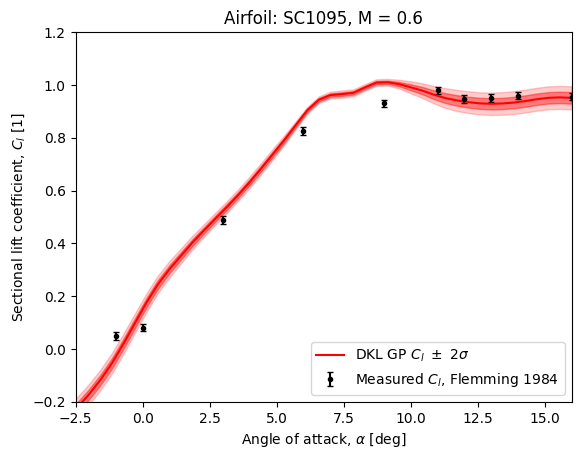

In [160]:
print(train_af.values)
cl_exp = [-0.505, -0.3, 0.049, 0.08, 0.489, 0.826, 0.93, 0.979, 0.947, 0.951, 0.959, 0.956]
alpha_exp = [-5, -3, -1, 0.0, 3, 6, 9, 11, 12, 13, 14, 16]
cl_xfoil = [-.4925, -.3165, -0.1147, 0.0244, 0.1920, 0.3598, 0.5301, 0.7022, 0.8757, 1.0543]
plt.errorbar(x=alpha_exp, y=cl_exp, yerr=2*0.007,fmt='k.',capsize=2, label='Measured $C_l$, Flemming 1984') # 0.007
plt.plot(alpha_vals, Cl_list, color='r',label='DKL GP $C_l \ \pm \ 2\sigma$')
plt.fill_between(alpha_vals, Cl_list-1*Cl_std_list, Cl_list+1*Cl_std_list,color='r',alpha=0.4)
plt.fill_between(alpha_vals, Cl_list-2*Cl_std_list, Cl_list+2*Cl_std_list,color='r',alpha=0.2)
# plt.plot(alpha_vals[2:2+len(cl_xfoil)], cl_xfoil, 'b--',label='XFOIL')
plt.legend(loc='lower right')
plt.xlabel('Angle of attack,' + r' $\alpha$ [deg]')
plt.ylabel('Sectional lift coefficient, $C_l$ [1]')
plt.title('Airfoil: SC1095, M = 0.6')
plt.xlim([-2.5, 16])
plt.ylim([-0.2, 1.2])
print(alpha_vals)


In [ ]:
print(np.diff(alpha_vals))